In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

from src.simplefact import *
from src.simplefact.syntax import *
from src.generate import *
from src.reasoner import *
from src.utils import *
from src.vis import *

seed = 2022

In [3]:
onto = load_ofn('local/out/dataset/pizza.ofn')
onto.use_annotations_as_names()
onto.use_prefix('pizza:')
fact = Reasoner.from_onto(onto=onto, timeout=None)
    
C = onto.concept_by_name
R = onto.role_by_name
onto

Unsupported class expression ('SubClassOf', 'pizza:American', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('SubClassOf', 'pizza:AmericanHot', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:America'))
Unsupported class expression ('EquivalentClasses', 'pizza:Country', ('ObjectIntersectionOf', 'pizza:DomainConcept', ('ObjectOneOf', 'pizza:America', 'pizza:England', 'pizza:France', 'pizza:Germany', 'pizza:Italy')))
Unsupported class expression ('EquivalentClasses', 'pizza:InterestingPizza', ('ObjectIntersectionOf', 'pizza:Pizza', ('ObjectMinCardinality', '3', 'pizza:hasTopping')))
Unsupported class expression ('SubClassOf', 'pizza:MozzarellaTopping', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('SubClassOf', 'pizza:Napoletana', ('ObjectHasValue', 'pizza:hasCountryOfOrigin', 'pizza:Italy'))
Unsupported class expression ('EquivalentClasses', 'pizza:RealItalianPizza', ('ObjectIntersection

FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


<Onto 99 concepts, 4 roles, 287 axioms>

In [4]:
queries, answers, qset = [], [], set()
concepts = list(range(onto.n_concepts)) + [TOP, BOT]

for c in concepts:
    for d in concepts:
        append_unique((SUB, c, d), queries, qset)

for query in queries:
    answers.append(float(fact.check_axiom(query)))

rng = np.random.default_rng(seed)
queries, answers = jointshuffle(rng, queries, answers)

print(len(answers))
print(np.mean(answers))

10201
0.09459856876776787


In [5]:
X_te = [core(x) for x in queries]
y_te = answers
idx_te = [0]*len(X_te)
data = idx_te, X_te, y_te

rng = np.random.default_rng(seed)
T.manual_seed(seed)
reasoner = NeuralReasoner(emb_size=10, hidden_size=16, onto=onto)
print('head params', paramcount(reasoner.head))
print('embs params', paramcount(reasoner.embs))

log = train(data, None, reasoner.head, [reasoner.embs], freeze_reasoner=False,
            epoch_count=30, batch_size=32, lr_reasoner=0.002, lr_encoder=0.002)

head params 3293
embs params 1430
train epoch 00/30 | batch 320/319 | loss 0.8002 | val loss 0.8002 | acc 0.0946 | f1 0.1728 | prec 0.0946 | recall 1.0000 | roc auc 0.4763 | pr auc 0.0948 | elapsed 3.22s
train epoch 01/30 | batch 320/319 | loss 0.3047 | val loss 0.1405 | acc 0.9613 | f1 0.7619 | prec 0.9107 | recall 0.6549 | roc auc 0.9144 | pr auc 0.8072 | elapsed 5.39s
train epoch 02/30 | batch 320/319 | loss 0.1331 | val loss 0.1208 | acc 0.9604 | f1 0.7543 | prec 0.9131 | recall 0.6425 | roc auc 0.9414 | pr auc 0.8440 | elapsed 5.09s
train epoch 03/30 | batch 320/319 | loss 0.1241 | val loss 0.1177 | acc 0.9613 | f1 0.7619 | prec 0.9107 | recall 0.6549 | roc auc 0.9467 | pr auc 0.8487 | elapsed 4.08s
train epoch 04/30 | batch 320/319 | loss 0.1222 | val loss 0.1159 | acc 0.9595 | f1 0.7414 | prec 0.9367 | recall 0.6135 | roc auc 0.9499 | pr auc 0.8560 | elapsed 4.23s
train epoch 05/30 | batch 320/319 | loss 0.1191 | val loss 0.1121 | acc 0.9630 | f1 0.7714 | prec 0.9298 | recall 0.

             mean  std     micro
acc      0.999804  NaN  0.999804
prec     1.000000  NaN  1.000000
recall   0.997927  NaN  0.997927
f1       0.998963  NaN  0.998963
auc_roc  1.000000  NaN  1.000000
auc_pr   1.000000  NaN  1.000000


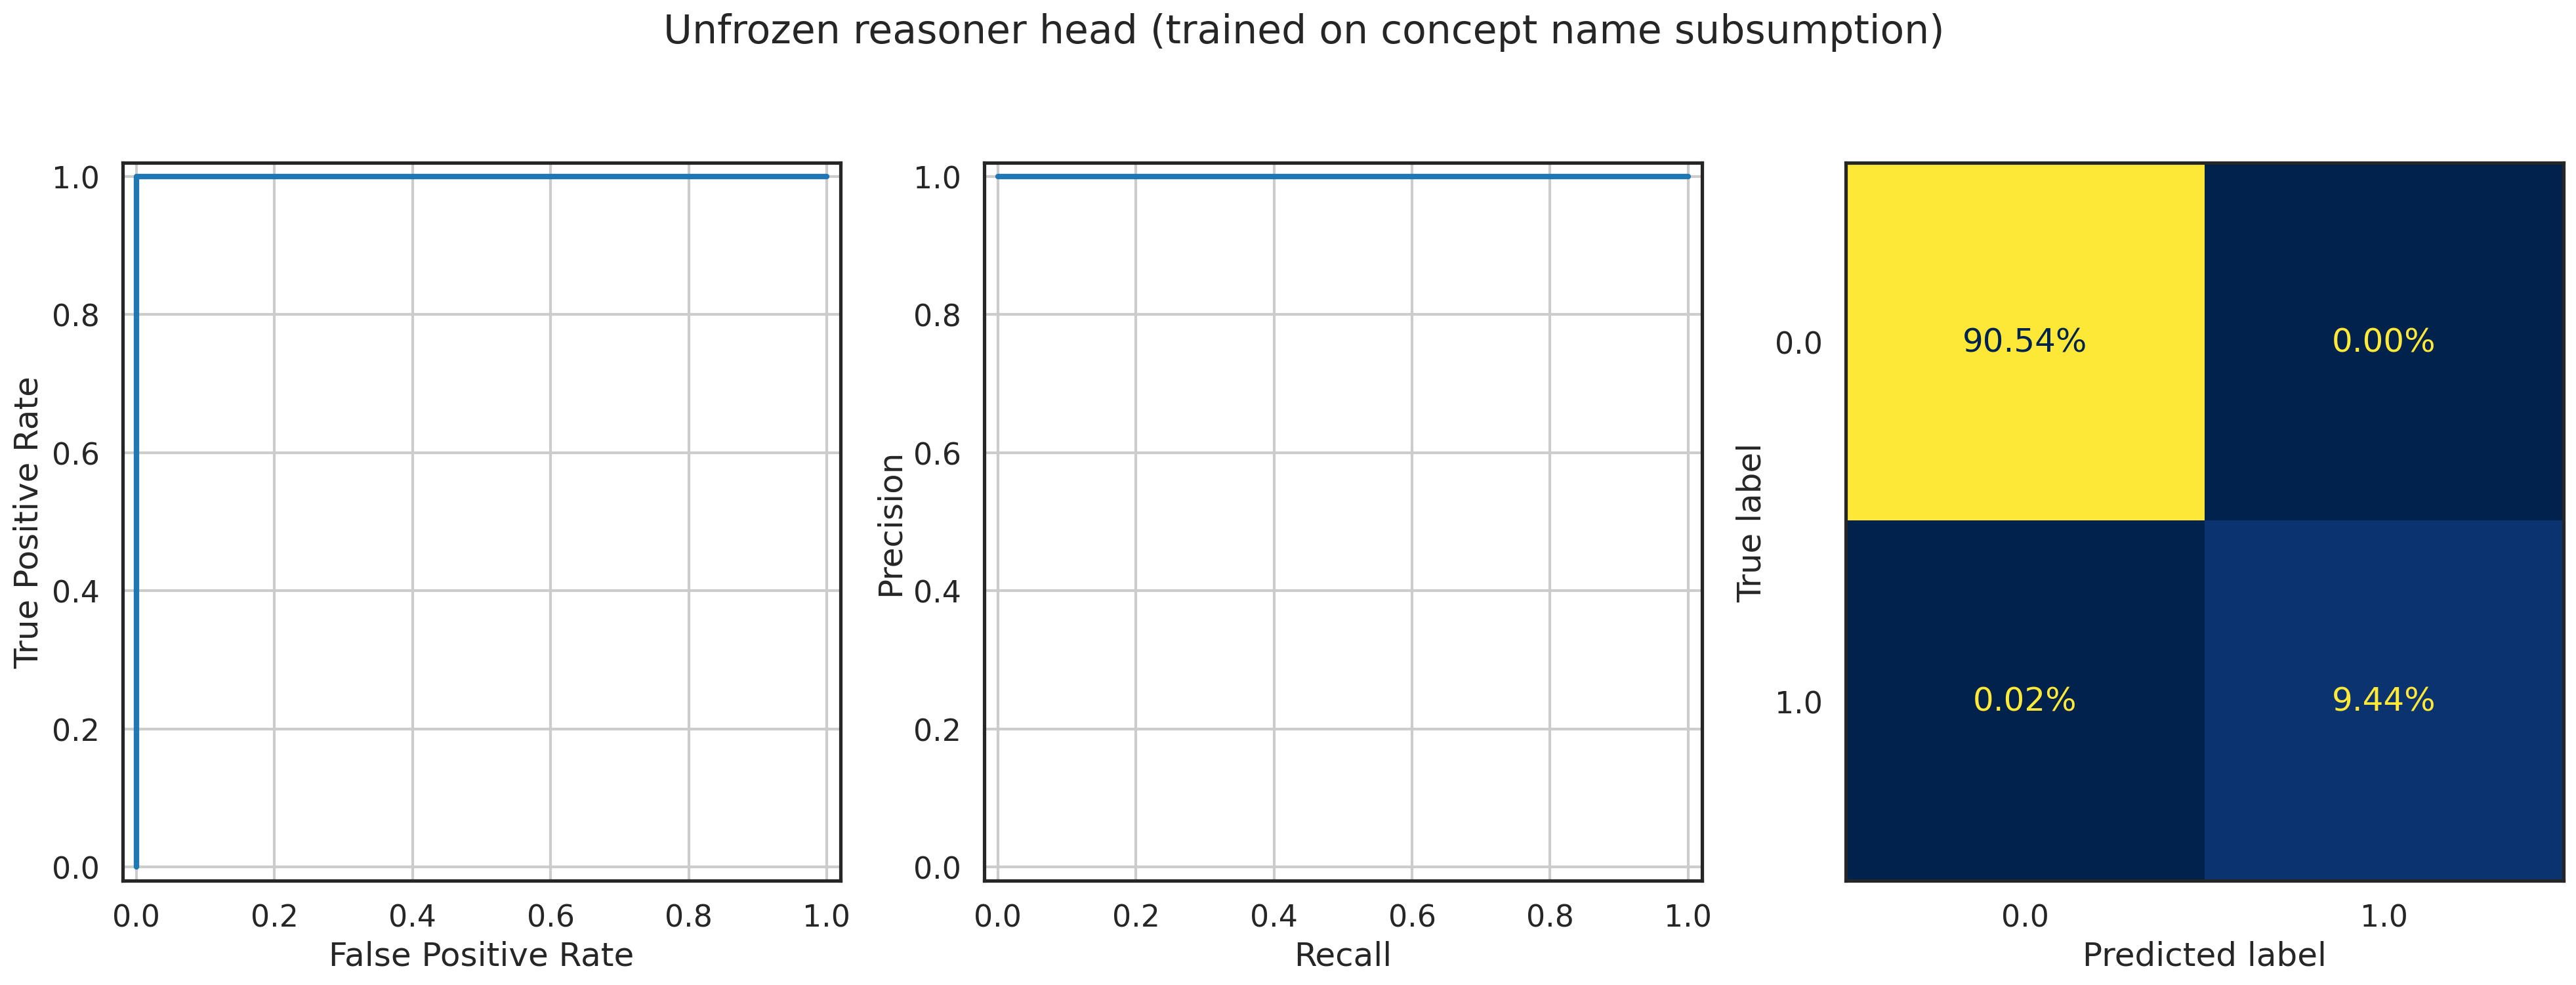

In [6]:
with T.no_grad():
    reasoner.eval()
    _, y_te, Y_te = eval_batch(reasoner.head, [reasoner.embs], X_te, y_te, idx_te)

print(report([onto], y_te, Y_te, idx_te))
plt.suptitle('Unfrozen reasoner head (trained on concept name subsumption)')
plt.show()

In [7]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te = np.array(Y_te)
y_te = np.array(y_te)
X_te = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te - y_te) > 0.3

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rekord': np.arange(len(X_te))[błędne_predykcje],
    'Prawdziwa Etykieta': y_te[błędne_predykcje],
    'Predykcja': Y_te[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'Feature_{i}' for i in range(X_te.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)

print(wyniki)

   Rekord  Prawdziwa Etykieta  Predykcja  Feature_0  Feature_1  Feature_2
0    1031                 1.0   0.506909          0         17         17
1    5690                 1.0   0.267483          0         37         37
2    6859                 1.0   0.572985          0         75         11
3   10059                 1.0   0.449514          0          1         11
